In [55]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")


In [56]:
def parse_fractional_price(s: str) -> float:
    """
    Convertit une chaîne du type '4 11/32' ou '4  5/16' en float (4.34375, etc.).
    Gère aussi les cas simples '4.25' ou '4'.
    Retourne np.nan si ce n'est pas parseable.
    """
    if pd.isna(s):
        return np.nan
    if not isinstance(s, str):
        try:
            return float(s)
        except Exception:
            return np.nan

    s = s.strip()

    # Cas simple : déjà un nombre décimal
    if re.fullmatch(r"\d+(\.\d+)?", s):
        try:
            return float(s)
        except Exception:
            return np.nan

    # Format '4 11/32'
    m = re.match(r"^(\d+)\s+(\d+)\s*/\s*(\d+)$", s)
    if m:
        base = float(m.group(1))
        num = float(m.group(2))
        den = float(m.group(3))
        return base + num / den

    # Format '11/32'
    m = re.match(r"^(\d+)\s*/\s*(\d+)$", s)
    if m:
        num = float(m.group(1))
        den = float(m.group(2))
        return num / den

    return np.nan


In [57]:
df_fast = pd.read_csv("data/fastmarket.csv")

df_fast["Date"] = pd.to_datetime(
    df_fast["Date"], 
    dayfirst=True,         # IMPORTANT
    errors="coerce"        # Met NaT si une ligne est vraiment bizarre
)

df_fast = df_fast.sort_values("Date").reset_index(drop=True)


df_fast = df_fast.rename(columns={
    "AG-CRN-0089": "cash_fob_decatur",
    "AG-CRN-0090": "basis_decatur",
    "AG-CRN-0074": "barge_premium_gulf",
    "AG-CRN-0075": "fob_gulf",
    "AG-CRN-0073": "cif_gulf",
})

df_fast.head()



,Date,cash_fob_decatur,basis_decatur,barge_premium_gulf,fob_gulf,cif_gulf
0,2000-09-15,1.71,NaN,NaN,NaN,NaN
1,2000-10-16,2.01,NaN,NaN,NaN,NaN
2,2000-10-17,2.01,NaN,NaN,NaN,NaN
3,2000-10-18,2.06,NaN,NaN,NaN,NaN
4,2000-10-19,1.99,NaN,NaN,NaN,NaN


In [58]:
df_fut = pd.read_csv("data/Cc1.csv")

# Date en datetime (format US)
df_fut["Date"] = pd.to_datetime(df_fut["Date"], dayfirst=False, errors="coerce")

df_fut = df_fut.sort_values("Date").reset_index(drop=True)
df_fut["close_decimal"] = df_fut["Close"].astype(str).apply(parse_fractional_price)

for col in ["Bid", "Ask"]:
    if col in df_fut.columns:
        df_fut[col + "_decimal"] = df_fut[col].astype(str).apply(parse_fractional_price)

df_fut[["Date", "Close", "close_decimal", "Bid", "Bid_decimal"]].head()

for col in ["Volume", "OI"]:
    df_fut[col] = (
        df_fut[col]
        .astype(str)
        .str.replace(" ", "", regex=False)   # supprime les espaces
        .str.replace(",", "", regex=False)   # au cas où
    )
    df_fut[col] = pd.to_numeric(df_fut[col], errors="coerce")



df_fut[["Date", "Close"]].head()
print(df_fut.tail())


           Date    Close       Net    %Chg     Open      Low     High  \
6522 2025-11-21  4  8/32         0  -0.23%  4  8/32  4  8/32  4  9/32   
6523 2025-11-24  4  8/32  -0.03125  -0.41%  4  8/32  4  7/32  4  8/32   
6524 2025-11-25  4  8/32         0  -0.06%  4  8/32  4  7/32  4  8/32   
6525 2025-11-26  4  5/16   0.09375   1.95%  4  7/32  4  7/32  4 11/32   
6526 2025-11-28  4 11/32   0.03125   0.87%  4  5/16  4  5/16  4  3/8    

        Volume        OI      Bid      Ask  close_decimal  Bid_decimal  \
6522  194578.0  221327.0  4  8/32  4  8/32        4.25000         4.25   
6523  227312.0  154610.0  4  8/32  4  8/32        4.25000         4.25   
6524  227795.0   79563.0  4  8/32  4  8/32        4.25000         4.25   
6525  158325.0   13468.0  4  8/32  4 11/32        4.31250         4.25   
6526    8642.0    8066.0  4  8/32  4  3/8         4.34375         4.25   

      Ask_decimal  
6522      4.25000  
6523      4.25000  
6524      4.25000  
6525      4.34375  
6526      4.3750

In [59]:
df_mkt = pd.merge(
    df_fast,
    df_fut[["Date", "close_decimal"]],
    on="Date",
    how="inner",  # seulement les dates communes pour commencer
)

df_mkt = df_mkt.sort_values("Date").reset_index(drop=True)
df_mkt.head()


,Date,cash_fob_decatur,basis_decatur,barge_premium_gulf,fob_gulf,cif_gulf,close_decimal
0,2000-09-15,1.71,NaN,NaN,NaN,NaN,1.84375
1,2000-10-16,2.01,NaN,NaN,NaN,NaN,2.03125
2,2000-10-17,2.01,NaN,NaN,NaN,NaN,2.03125
3,2000-10-18,2.06,NaN,NaN,NaN,NaN,2.03125
4,2000-10-19,1.99,NaN,NaN,NaN,NaN,2.03125


In [60]:
df_mkt["basis_decatur_from_prices"] = df_mkt["cash_fob_decatur"] - df_mkt["close_decimal"]

df_mkt["spread_cif_fob_gulf"] = df_mkt["cif_gulf"] - df_mkt["fob_gulf"]
df_mkt["spread_fob_decatur_gulf"] = df_mkt["fob_gulf"] - df_mkt["cash_fob_decatur"]

df_mkt[[
    "Date",
    "cash_fob_decatur",
    "basis_decatur",
    "close_decimal",
    "basis_decatur_from_prices",
    "barge_premium_gulf",
    "cif_gulf",
    "fob_gulf",
    "spread_cif_fob_gulf",
]].head()

df_mkt = df_mkt[df_mkt["Date"] >= "2001-01-01"].copy()


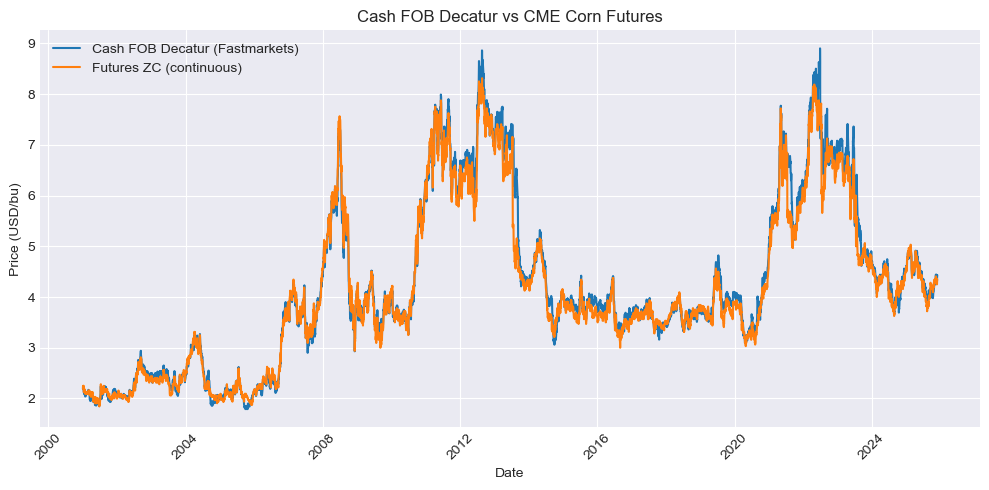

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(df_mkt["Date"], df_mkt["cash_fob_decatur"], label="Cash FOB Decatur (Fastmarkets)")
plt.plot(df_mkt["Date"], df_mkt["close_decimal"], label="Futures ZC (continuous)")
plt.legend()
plt.title("Cash FOB Decatur vs CME Corn Futures")
plt.xlabel("Date")
plt.ylabel("Price (USD/bu)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


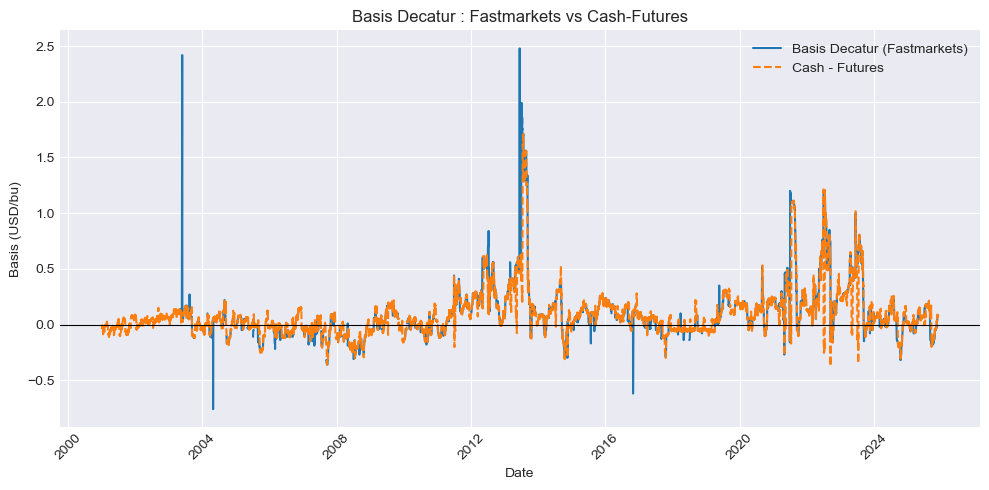

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(df_mkt["Date"], df_mkt["basis_decatur"], label="Basis Decatur (Fastmarkets)")
plt.plot(df_mkt["Date"], df_mkt["basis_decatur_from_prices"], label="Cash - Futures", linestyle="--")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Basis Decatur : Fastmarkets vs Cash-Futures")
plt.xlabel("Date")
plt.ylabel("Basis (USD/bu)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


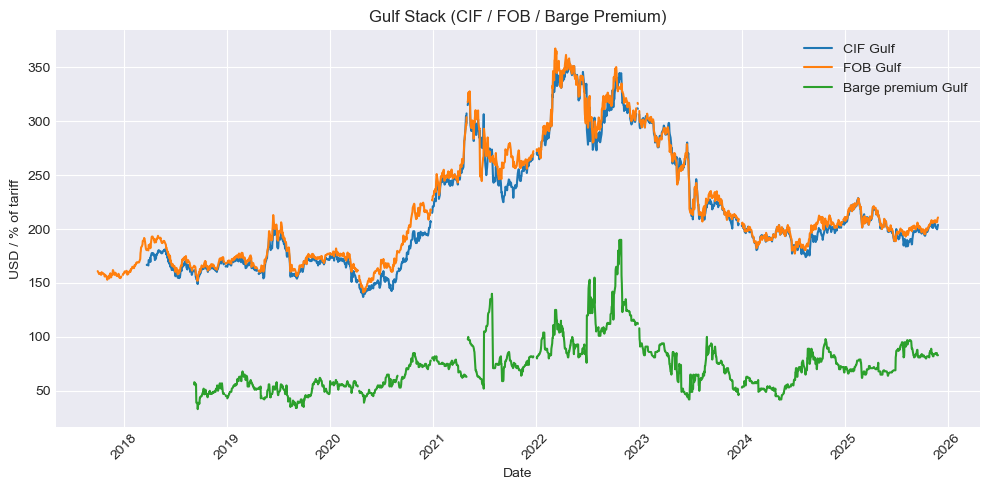

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(df_mkt["Date"], df_mkt["cif_gulf"], label="CIF Gulf")
plt.plot(df_mkt["Date"], df_mkt["fob_gulf"], label="FOB Gulf")
plt.plot(df_mkt["Date"], df_mkt["barge_premium_gulf"], label="Barge premium Gulf")
plt.legend()
plt.title("Gulf Stack (CIF / FOB / Barge Premium)")
plt.xlabel("Date")
plt.ylabel("USD / % of tariff")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [64]:
# On choisit le basis Fastmarkets comme série de référence
df_mkt = df_mkt.copy()
df_mkt["basis"] = df_mkt["basis_decatur"]

# Semaine de l'année (ISO)
df_mkt["week_of_year"] = df_mkt["Date"].dt.isocalendar().week.astype(int)

# Moyenne et std du basis par semaine de l'année (toutes années confondues)
basis_group = df_mkt.groupby("week_of_year")["basis"]
basis_mean_week = basis_group.transform("mean")
basis_std_week = basis_group.transform("std")

# Z-score saisonnalisé
df_mkt["basis_z"] = (df_mkt["basis"] - basis_mean_week) / basis_std_week

df_mkt[["Date", "basis", "basis_z"]].tail()


,Date,basis,basis_z
6299,2025-11-21,0.08,-0.218292
6300,2025-11-24,0.08,-0.115871
6301,2025-11-25,0.08,-0.115871
6302,2025-11-26,0.08,-0.115871
6303,2025-11-28,0.08,-0.115871


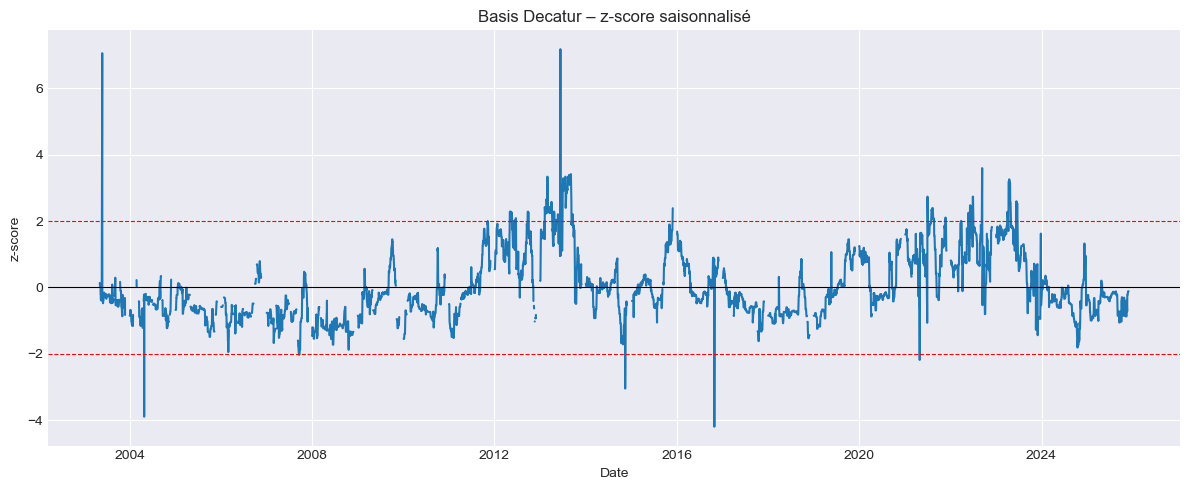

In [65]:

plt.figure(figsize=(12, 5))
plt.plot(df_mkt["Date"], df_mkt["basis_z"])
plt.axhline(0, color="black", linewidth=0.8)
plt.axhline(2, color="red", linestyle="--", linewidth=0.8)
plt.axhline(-2, color="red", linestyle="--", linewidth=0.8)
plt.title("Basis Decatur – z-score saisonnalisé")
plt.ylabel("z-score")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


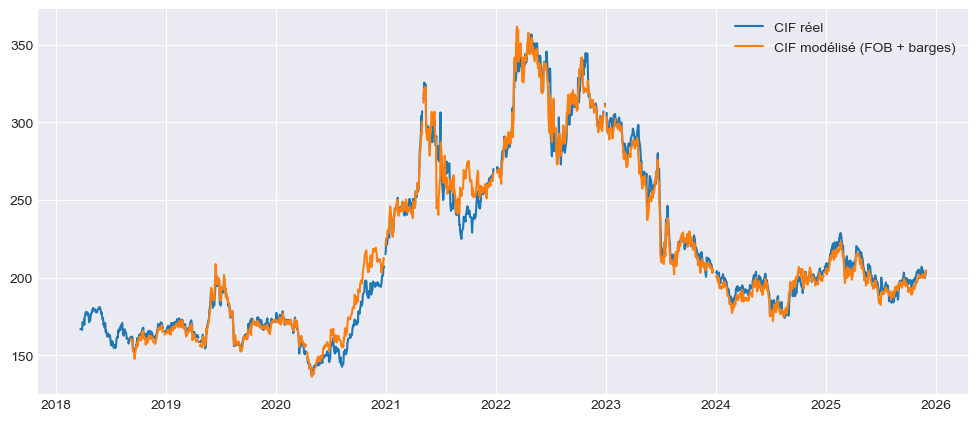

/var/folders/17/1l32x0xd6fdgz42c_pz2rhmm0000gn/T/ipykernel_65727/251805719.py:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_mkt["cif_return_5d"] = df_mkt["cif_gulf"].pct_change(5).shift(-5)


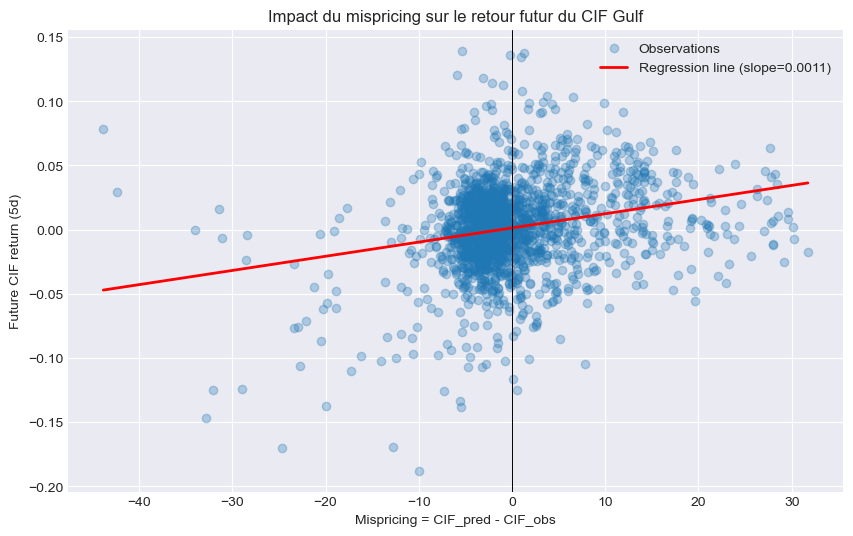

Slope (beta): 0.0011047366256045081
Intercept: 0.0012942232406113552


In [90]:
from numpy.linalg import lstsq

# On garde les lignes où toutes les données Gulf sont présentes
mask_gulf = df_mkt[["cif_gulf", "fob_gulf", "barge_premium_gulf"]].notna().all(axis=1)
gulf_df = df_mkt.loc[mask_gulf, ["cif_gulf", "fob_gulf", "barge_premium_gulf"]].copy()

# Matrice X = [1, FOB, BargePremium]
X = np.column_stack([
    np.ones(len(gulf_df)),
    gulf_df["fob_gulf"].values,
    gulf_df["barge_premium_gulf"].values,
])
y = gulf_df["cif_gulf"].values

# Régression OLS : y ≈ X @ beta
beta, *_ = lstsq(X, y, rcond=None)
alpha, beta_fob, beta_barge = beta
alpha, beta_fob, beta_barge

# CIF "modélisé" (ce que le modèle attend)
cif_hat = X @ beta
residual = y - cif_hat
resid_std = residual.std()

gulf_df["cif_pred"] = cif_hat


gulf_df["gulf_mispricing_raw"] = residual
gulf_df["gulf_mispricing_z"] = residual / resid_std

# On recolle à df_mkt
df_mkt["gulf_mispricing_z"] = np.nan
df_mkt.loc[mask_gulf, "gulf_mispricing_z"] = gulf_df["gulf_mispricing_z"].values

df_mkt["cif_pred"] = np.nan
df_mkt.loc[mask_gulf, "cif_pred"] = gulf_df["cif_pred"].values


df_mkt["mispricing"] = df_mkt["cif_pred"] - df_mkt["cif_gulf"]

mu = df_mkt["mispricing"].mean()
sigma = df_mkt["mispricing"].std()

df_mkt["mispricing_z"] = (df_mkt["mispricing"] - mu) / sigma


plt.figure(figsize=(12,5))
plt.plot(df_mkt["Date"], df_mkt["cif_gulf"], label="CIF réel")
plt.plot(df_mkt["Date"], df_mkt["cif_pred"], label="CIF modélisé (FOB + barges)")
plt.legend()
plt.show()

df_mkt["cif_return_5d"] = df_mkt["cif_gulf"].pct_change(5).shift(-5)

mask = df_mkt["mispricing"].notna() & df_mkt["cif_return_5d"].notna()
x = df_mkt.loc[mask, "mispricing"].values.reshape(-1, 1)
y = df_mkt.loc[mask, "cif_return_5d"].values

# Fit de régression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)

x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.3, label="Observations")
plt.plot(x_line, y_line, color="red", linewidth=2, label=f"Regression line (slope={model.coef_[0]:.4f})")
plt.axvline(0, color="black", linewidth=0.7)
plt.xlabel("Mispricing = CIF_pred - CIF_obs")
plt.ylabel("Future CIF return (5d)")
plt.title("Impact du mispricing sur le retour futur du CIF Gulf")
plt.legend()
plt.grid(True)
plt.show()

print("Slope (beta):", model.coef_[0])
print("Intercept:", model.intercept_)





/var/folders/17/1l32x0xd6fdgz42c_pz2rhmm0000gn/T/ipykernel_65727/2439623733.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_mkt["cif_ret"] = df_mkt["cif_gulf"].pct_change()


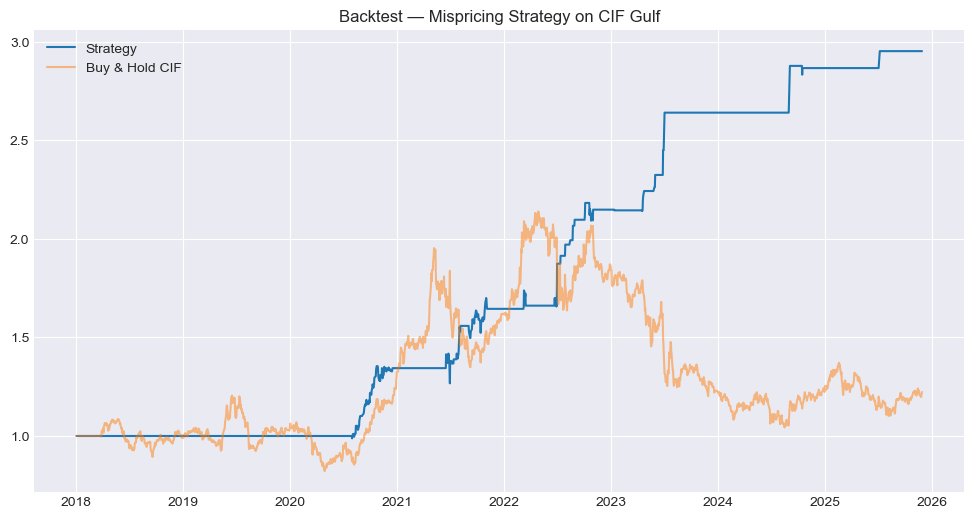

In [95]:
def get_position(z):
    if z > 1.5:
        return 1       # Long CIF
    elif z < -1.5:
        return -1      # Short CIF
    else:
        return 0

df_mkt["position_raw"] = df_mkt["mispricing_z"].apply(get_position)

# Pas de lookahead : position appliquée le lendemain
df_mkt["position"] = df_mkt["position_raw"].shift(1).fillna(0)

df_mkt["cif_ret"] = df_mkt["cif_gulf"].pct_change()
df_mkt["strategy_ret"] = df_mkt["position"] * df_mkt["cif_ret"]

df_mkt["equity_strategy"] = (1 + df_mkt["strategy_ret"].fillna(0)).cumprod()
df_mkt["equity_cif"] = (1 + df_mkt["cif_ret"].fillna(0)).cumprod()

df_mkt = df_mkt[df_mkt["Date"] >= "2018-01-01"].copy()

plt.figure(figsize=(12,6))
plt.plot(df_mkt["Date"], df_mkt["equity_strategy"], label="Strategy")
plt.plot(df_mkt["Date"], df_mkt["equity_cif"], label="Buy & Hold CIF", alpha=0.5)
plt.legend()
plt.title("Backtest — Mispricing Strategy on CIF Gulf")
plt.grid(True)
plt.show()



In [96]:
def perf_stats(returns):
    total_ret = (1 + returns).prod() - 1
    annual_days = 252
    cagr = (1 + total_ret) ** (annual_days / len(returns)) - 1
    vol = returns.std() * np.sqrt(annual_days)
    sharpe = cagr / vol if vol > 0 else np.nan
    max_dd = (1 + returns).cumprod().cummax() - (1 + returns).cumprod()
    max_dd = max_dd.max()
    winrate = (returns > 0).mean()
    return {
        "Total Return": total_ret,
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "WinRate": winrate,
    }

stats = perf_stats(df_mkt["strategy_ret"].dropna())
stats


{'Total Return': np.float64(1.9530867897423767),
 'CAGR': np.float64(0.15153446731614384),
 'Volatility': np.float64(0.1085381288592804),
 'Sharpe': np.float64(1.396140406221745),
 'MaxDD': np.float64(0.15109719205141658),
 'WinRate': np.float64(0.05894519131334023)}